In [1]:
import pickle
from pandas import DataFrame
import pandas as pd
import numpy as np
import math

state_df = pickle.load(open("test/local_node/state/0x85Cb0baB616Fe88a89A35080516a8928F38B518b_df.pkl", "rb"))
state_df.head()

,sender,to,amount0In,amount1In,amount0Out,amount1Out,block,reserve0,reserve1
0,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,0,1000000000000000000,17216867992651970607,0,11876000,25851205000000000000,500000000000000000
1,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,172168679926519706,0,0,29238993545300586,11876000,8634337007348029393,1500000000000000000
2,0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D,0x6775e49108cb77cda06Fc3BEF51bcD497602aD88,0,224702378222482754,1220961301500860191,0,11876017,13596682010212464215,2270761006454699413
3,0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D,0x6775e49108cb77cda06Fc3BEF51bcD497602aD88,0,274957939374967319,1224941726101556768,0,11876020,12375720708711604024,2495463384677182167
4,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,17044699312725450901,0,0,1672781398369595795,11876026,11150778982610047256,2770421324052149486


# Transform to a per block index

In [2]:
block_df = (state_df[['block', 'amount0In', 'amount1In', 'amount0Out', 'amount1Out', 'reserve0', 'reserve1']]).groupby(
    state_df.block, as_index=False).agg({
        'block': 'first', 'amount0In': sum, 'amount1In': sum, 'amount0Out': sum, 'amount1Out': sum, 'reserve0': 'last', 'reserve1': 'last'
    })
block_df.block = block_df.block.astype(int)

block_df = block_df.set_index('block').reindex(np.arange(block_df.block.min(), block_df.block.max() + 1)).reset_index()
block_df.reserve0 = block_df.reserve0.fillna(method='ffill')
block_df.reserve1 = block_df.reserve1.fillna(method='ffill')
block_df = block_df.fillna(value=0)
block_df.head()


,block,amount0In,amount1In,amount0Out,amount1Out,reserve0,reserve1
0,11876000,172168679926519706,1000000000000000000,17216867992651970607,29238993545300586,8634337007348029393,1500000000000000000
1,11876001,0,0,0,0,8634337007348029393,1500000000000000000
2,11876002,0,0,0,0,8634337007348029393,1500000000000000000
3,11876003,0,0,0,0,8634337007348029393,1500000000000000000
4,11876004,0,0,0,0,8634337007348029393,1500000000000000000


# Construct Oracles

Our dataframe starts with swaps and reserves prior to swaps. Using this data we crunch some numbers to build build various oraclse. Since we do not have time which our scanner does not grab, we use blocks thus BWAP rather than TWAP. If every block was 12 seconds exactly, this would be the same, but since that is not the case, there are some minor erorrs. 

In [3]:
tick_log = math.log(1.0001)


# additive TWAP
oracle_df = block_df
oracle_df["cumsum_x_per_y"] = (block_df['reserve0'] / block_df['reserve1']).cumsum()
oracle_df["cumsum_y_per_x"] = (block_df['reserve1'] / block_df['reserve0']).cumsum()


oracle_df["twap_30_x_per_y"] = (oracle_df["cumsum_x_per_y"] - oracle_df["cumsum_x_per_y"].shift(periods=150)) / 150
oracle_df["twap_30_y_per_x"] = (oracle_df["cumsum_y_per_x"] - oracle_df["cumsum_y_per_x"].shift(periods=150)) / 150
oracle_df["twap_60_x_per_y"] = (oracle_df["cumsum_x_per_y"] - oracle_df["cumsum_x_per_y"].shift(periods=300)) / 300
oracle_df["twap_60_y_per_x"] = (oracle_df["cumsum_y_per_x"] - oracle_df["cumsum_y_per_x"].shift(periods=300)) / 300

# Geometric TWAP
oracle_df["tick_sum_x_per_y"] = (np.log((block_df['reserve0'] / block_df['reserve1']).astype(float)) /
                                tick_log).cumsum()

oracle_df["geom_twap_30_x_per_y"] = np.power(
    1.0001, (oracle_df["tick_sum_x_per_y"] - oracle_df["tick_sum_x_per_y"].shift(150)) / 150
)
oracle_df["geom_twap_60_x_per_y"] = np.power(
    1.0001, (oracle_df["tick_sum_x_per_y"] - oracle_df["tick_sum_x_per_y"].shift(300)) / 300
)


# # VWAP
oracle_df["cumsum_x_in"] = block_df["amount0In"].cumsum()
oracle_df["cumsum_y_out"] = block_df["amount1Out"].cumsum()
oracle_df["cumsum_y_in"] = block_df["amount1In"].cumsum()
oracle_df["cumsum_x_out"] = block_df["amount0Out"].cumsum()

oracle_df["vwap_30_x_per_y"] = (
        oracle_df["cumsum_x_in"] + oracle_df["cumsum_x_out"] -
        (oracle_df["cumsum_x_in"] + oracle_df["cumsum_x_out"]).shift(150)).divide(
        (oracle_df["cumsum_y_in"] + oracle_df["cumsum_y_out"] -
        (oracle_df["cumsum_y_in"] + oracle_df["cumsum_y_out"]).shift(150)).replace({ 0 : np.nan }))

oracle_df.head()


,block,amount0In,amount1In,amount0Out,amount1Out,reserve0,reserve1,cumsum_x_per_y,cumsum_y_per_x,twap_30_x_per_y,...,twap_60_x_per_y,twap_60_y_per_x,tick_sum_x_per_y,geom_twap_30_x_per_y,geom_twap_60_x_per_y,cumsum_x_in,cumsum_y_out,cumsum_y_in,cumsum_x_out,vwap_30_x_per_y
0,11876000,172168679926519706,1000000000000000000,17216867992651970607,29238993545300586,8634337007348029393,1500000000000000000,5.756225,0.173725,NaN,...,NaN,NaN,17503.693335,NaN,NaN,172168679926519706,29238993545300586,1000000000000000000,17216867992651970607,NaN
1,11876001,0,0,0,0,8634337007348029393,1500000000000000000,11.512449,0.34745,NaN,...,NaN,NaN,35007.386670,NaN,NaN,172168679926519706,29238993545300586,1000000000000000000,17216867992651970607,NaN
2,11876002,0,0,0,0,8634337007348029393,1500000000000000000,17.268674,0.521175,NaN,...,NaN,NaN,52511.080004,NaN,NaN,172168679926519706,29238993545300586,1000000000000000000,17216867992651970607,NaN
3,11876003,0,0,0,0,8634337007348029393,1500000000000000000,23.024899,0.6949,NaN,...,NaN,NaN,70014.773339,NaN,NaN,172168679926519706,29238993545300586,1000000000000000000,17216867992651970607,NaN
4,11876004,0,0,0,0,8634337007348029393,1500000000000000000,28.781123,0.868625,NaN,...,NaN,NaN,87518.466674,NaN,NaN,172168679926519706,29238993545300586,1000000000000000000,17216867992651970607,NaN


# 30 Minute Oracle Comparison

In [4]:
oracle_df.iloc[150:][['block', 'twap_30_x_per_y', 'geom_twap_30_x_per_y', 'vwap_30_x_per_y']]

,block,twap_30_x_per_y,geom_twap_30_x_per_y,vwap_30_x_per_y
150,11876150,89.092638,48.065748,107.187049
151,11876151,90.490603,49.240650,107.187049
152,11876152,91.888569,50.444272,107.187049
153,11876153,93.286535,51.677313,107.187049
154,11876154,94.684501,52.940495,107.187049
...,...,...,...,...
4603584,16479584,1611.792365,1611.792362,NaN
4603585,16479585,1611.792365,1611.792362,NaN
4603586,16479586,1611.792365,1611.792362,NaN
4603587,16479587,1611.792365,1611.792362,NaN


In [5]:
average_price_df = oracle_df.iloc[150:][['block', 'twap_30_x_per_y', 'geom_twap_30_x_per_y', 'vwap_30_x_per_y']]
average_price_df["current_price"] = (oracle_df['reserve0'] / oracle_df['reserve1'])
average_price_df["shifted_price"] = (oracle_df['reserve0'] / oracle_df['reserve1']).shift(periods=75)
average_price_df = average_price_df.set_index('block')

<AxesSubplot: xlabel='block'>

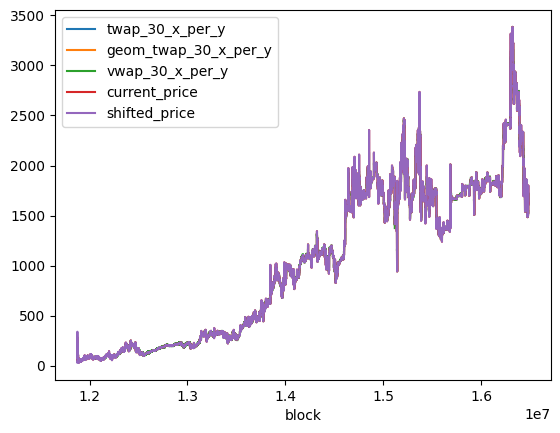

In [6]:
average_price_df.plot()

<AxesSubplot: xlabel='block'>

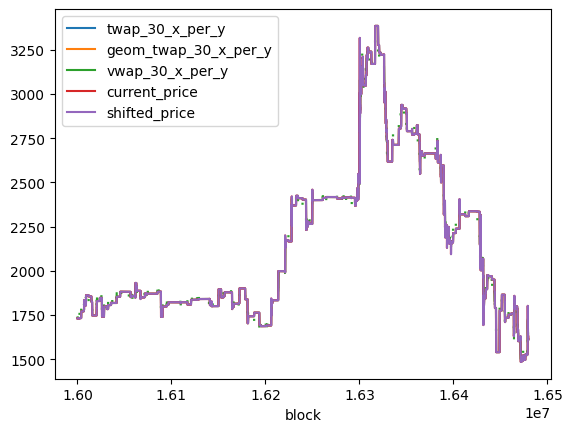

In [7]:
average_price_df[16000000 < average_price_df.index].plot()

<AxesSubplot: xlabel='block'>

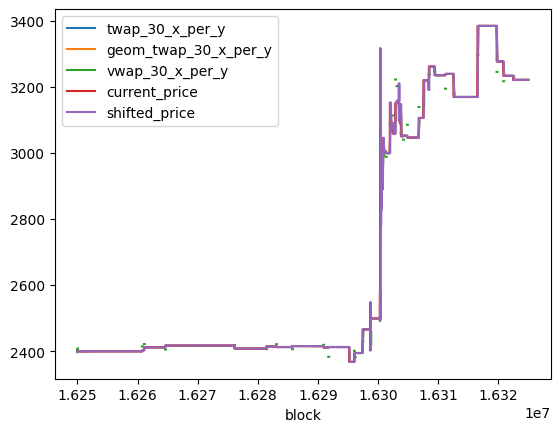

In [8]:
average_price_df[(16250000 <= average_price_df.index) & (average_price_df.index <= 16325000)].plot()

<AxesSubplot: xlabel='block'>

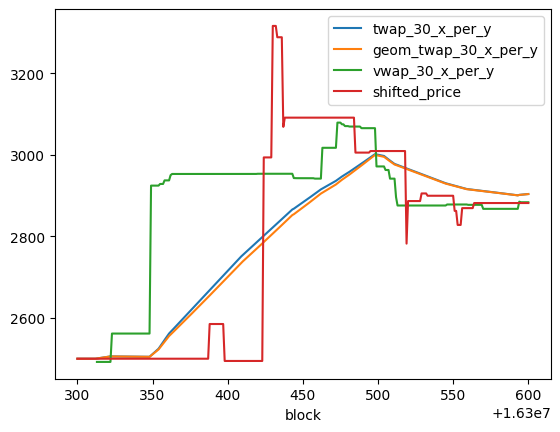

In [9]:
average_price_df.drop('current_price', axis=1)[(16300300 <= average_price_df.index) & (average_price_df.index <= 16300600)].plot()